# Full Pipeline: Production Regime Detection

**From Manual HMM to Production-Ready Pipeline**

## Your Learning Journey So Far

### Notebook 1: Mathematical Foundation
You learned **WHY** we use log returns:
- ✓ Stationarity (required for HMMs)
- ✓ Time additivity (returns simply add)
- ✓ Scale invariance (compare $60 and $500 stocks)
- ✓ Symmetric treatment (gains/losses balanced)
- ✓ Cross-asset comparability

**Key Takeaway**: Log returns aren't convention—they're mathematical necessity.

### Notebook 2: HMM Mechanics
You learned **HOW** HMMs work:
- ✓ Hidden states represent market regimes
- ✓ Transition matrices capture regime persistence
- ✓ Emission parameters (μ, σ) define regime characteristics
- ✓ Viterbi algorithm finds most likely state sequence
- ✓ Forward-backward gives probability distributions

**Key Takeaway**: Don't force "Bear/Bull" labels—let data reveal regimes.

### Notebook 3: Production Pipeline (This Notebook)
You'll learn **USING** the pipeline for real analysis:
- ✓ One-line pipeline setup (production efficiency)
- ✓ Automated regime labeling (threshold-based logic)
- ✓ Regime characteristics and persistence
- ✓ Choosing optimal number of states
- ✓ Best practices for regime detection

**Scope Note**: This notebook focuses on **regime detection**. For trading applications (risk management, position sizing, backtesting), see **Notebook 4**.

---

## What This Notebook Covers

**Part 1**: Quick Pipeline Setup (Sections 1-2)

**Part 2**: Understanding Regime Classification (Sections 3-4)

**Part 3**: Regime Duration & Persistence (Section 5)

**Part 4**: Visualization (Section 6)

**Part 5**: Model Selection (Section 7)

**Part 6**: Best Practices & Next Steps (Section 8)

---

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Add parent to path
sys.path.insert(0, str(Path().absolute().parent))

# Import hidden_regime using the full API
import hidden_regime as hr

# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(sns.color_palette())

print("Imports complete")
print(f"hidden-regime version: {hr.__version__}")

Imports complete
hidden-regime version: 1.0.0


## 1. Quick Start: Pipeline Factory

The library provides factory functions for quick pipeline creation.

In [2]:
# Create a complete financial pipeline with one function call
ticker = 'NVDA'
n_states = 3

pipeline = hr.create_financial_pipeline(
    ticker=ticker,
    n_states=n_states,
    include_report=False  # We'll do custom analysis
)

# Display pipeline components
print(f"Pipeline created for {ticker} with {n_states} states")
print(f"  Data loader: {type(pipeline.data).__name__}")
print(f"  Observations: {type(pipeline.observation).__name__}")
print(f"  Model: {type(pipeline.model).__name__}")
print(f"  Analysis: {type(pipeline.analysis).__name__}")

Pipeline created for NVDA with 3 states
  Data loader: FinancialDataLoader
  Observations: FinancialObservationGenerator
  Model: HiddenMarkovModel
  Analysis: FinancialAnalysis


## 2. Run the Complete Pipeline

The `pipeline.update()` method executes all stages:
1. **Data loading**: Downloads historical price data
2. **Observation generation**: Computes log returns
3. **Model training**: Fits HMM using Baum-Welch algorithm
4. **Analysis**: Generates regime classifications and metrics

In [3]:
# Execute pipeline
report = pipeline.update()

# Get analysis results
result = pipeline.component_outputs['analysis']

# Display summary
print(f"Analysis complete: {result.shape[0]} days, {result.shape[1]} metrics")
print(f"Date range: {result.index[0].date()} to {result.index[-1].date()}")

Training on 500 observations (removed 0 NaN values)
Analysis complete: 500 days, 37 metrics
Date range: 2023-10-17 to 2025-10-14


## 3. Threshold-Based Regime Mapping

### How Regimes Are Classified

The library uses **data-driven thresholds** on emission means $\mu_k$:

$$
\text{regime}_k = \begin{cases}
\text{Bear} & \text{if } \mu_k < \theta_{\text{bear}} \\
\text{Bull} & \text{if } \mu_k > \theta_{\text{bull}} \\
\text{Sideways} & \text{otherwise}
\end{cases}
$$

Where $\theta_{\text{bear}}$ and $\theta_{\text{bull}}$ are determined by:
- Historical return distributions
- Volatility-adjusted cutoffs
- Statistical significance tests

**Key Point**: We do NOT sort states by index and assign "State 0 = Bear, State 1 = Sideways, State 2 = Bull". The **data** reveals the regime types.

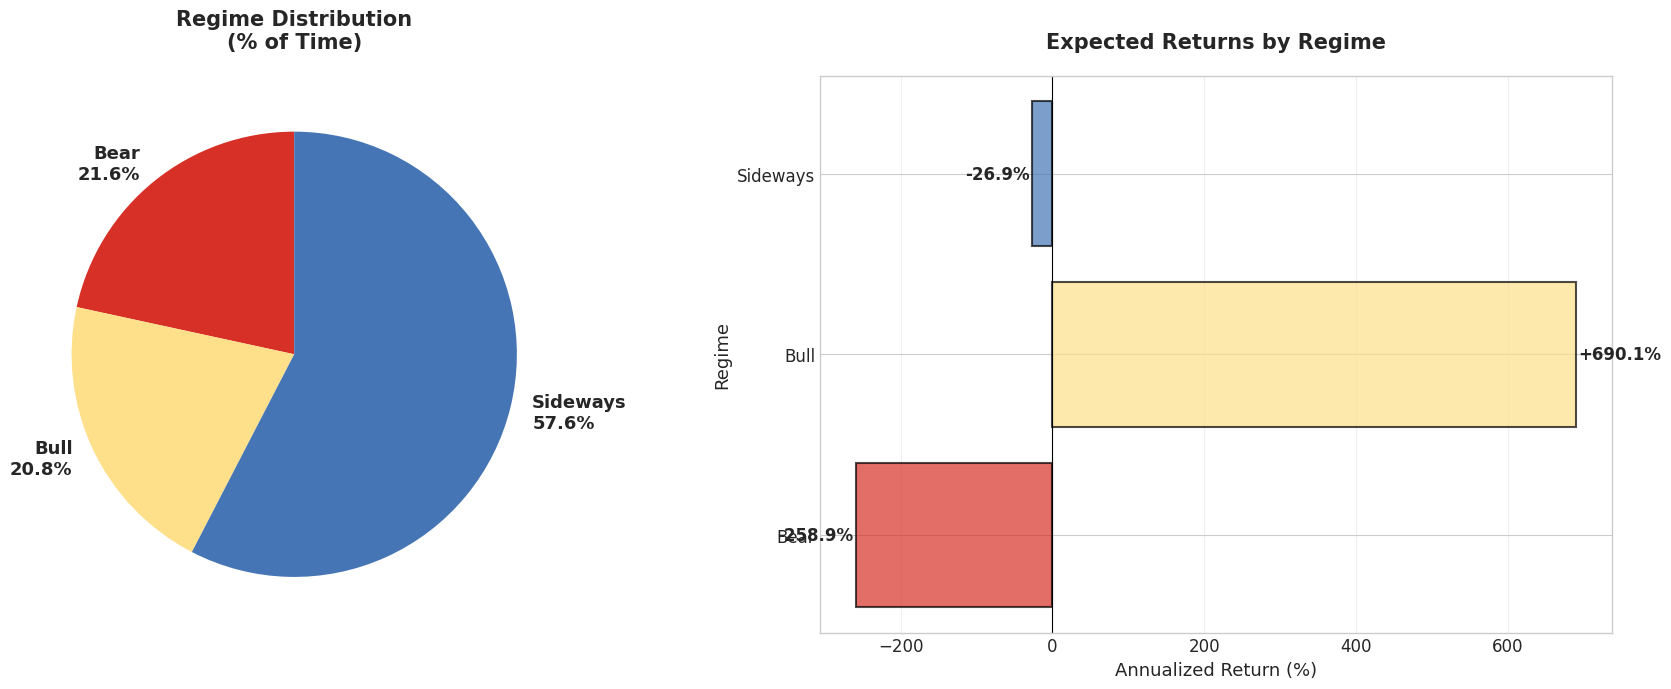


Detailed Regime Characteristics

Bear (State 0)
--------------------------------------------------------------------------------
  Frequency:   108 days (21.6% of period)
  Daily:       mu = -1.027%  sigma = 4.131%
  Annualized:  mu = -258.9%  sigma = 65.6%

Bull (State 2)
--------------------------------------------------------------------------------
  Frequency:   104 days (20.8% of period)
  Daily:       mu = +2.739%  sigma = 1.221%
  Annualized:  mu = +690.1%  sigma = 19.4%

Sideways (State 1)
--------------------------------------------------------------------------------
  Frequency:   288 days (57.6% of period)
  Daily:       mu = -0.107%  sigma = 1.356%
  Annualized:  mu = -26.9%  sigma = 21.5%


In [4]:
# Get raw data with log returns
raw_data = pipeline.data.get_all_data()

# Find log_return column (case-insensitive)
log_return_col = None
for col in raw_data.columns:
    if col.lower() == 'log_return':
        log_return_col = col
        break

# Prepare regime data for visualization
regimes = result['regime_name'].unique()
regime_stats = []

for regime in sorted(regimes):
    regime_data = result[result['regime_name'] == regime]
    n_days = len(regime_data)
    pct_time = n_days / len(result) * 100
    state_num = regime_data['predicted_state'].iloc[0]
    
    stats = {
        'regime': regime,
        'state': state_num,
        'days': n_days,
        'pct_time': pct_time
    }
    
    # Get log returns for this regime by aligning indices
    if log_return_col is not None:
        regime_indices = regime_data.index
        obs_returns = raw_data.loc[regime_indices, log_return_col].dropna()
        
        if len(obs_returns) > 0:
            avg_log = obs_returns.mean()
            avg_pct = hr.log_return_to_percent_change(avg_log) * 100
            vol_daily = obs_returns.std() * 100
            vol_annual = vol_daily * np.sqrt(252)
            
            stats.update({
                'daily_return': avg_pct,
                'daily_vol': vol_daily,
                'annual_return': avg_pct * 252,
                'annual_vol': vol_annual
            })
    
    regime_stats.append(stats)

# Create visualization with larger figure size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Get regime colors
unique_regimes = sorted(result['regime_name'].unique())
from hidden_regime.visualization import get_regime_colors
color_list = get_regime_colors(len(unique_regimes), color_scheme="colorblind_safe")
regime_colors = dict(zip(unique_regimes, color_list))

# Left: Pie chart of regime distribution
sizes = [s['pct_time'] for s in regime_stats]
labels = [f"{s['regime']}\n{s['pct_time']:.1f}%" for s in regime_stats]
colors = [regime_colors[s['regime']] for s in regime_stats]

wedges, texts, autotexts = ax1.pie(sizes, labels=labels, colors=colors, autopct='',
                                     startangle=90, textprops={'fontsize': 13, 'fontweight': 'bold'})
ax1.set_title('Regime Distribution\n(% of Time)', fontsize=15, fontweight='bold', pad=20)

# Right: Bar chart of returns by regime
regime_names = [s['regime'] for s in regime_stats]
returns = [s.get('annual_return', 0) for s in regime_stats]
bar_colors = [regime_colors[s['regime']] for s in regime_stats]

bars = ax2.barh(regime_names, returns, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Annualized Return (%)', fontsize=13)
ax2.set_ylabel('Regime', fontsize=13)
ax2.set_title('Expected Returns by Regime', fontsize=15, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, axis='x')
ax2.tick_params(axis='both', labelsize=12)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, returns)):
    if val != 0:  # Only add label if we have data
        label_x = val + (3 if val > 0 else -3)
        ha = 'left' if val > 0 else 'right'
        ax2.text(label_x, bar.get_y() + bar.get_height()/2, 
                 f'{val:+.1f}%', ha=ha, va='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Regime Characteristics")
print("=" * 80)
for s in regime_stats:
    print(f"\n{s['regime']} (State {s['state']})")
    print("-" * 80)
    print(f"  Frequency:   {s['days']} days ({s['pct_time']:.1f}% of period)")
    if 'daily_return' in s:
        print(f"  Daily:       mu = {s['daily_return']:+.3f}%  sigma = {s['daily_vol']:.3f}%")
        print(f"  Annualized:  mu = {s['annual_return']:+.1f}%  sigma = {s['annual_vol']:.1f}%")
print("=" * 80)

## 4. Current Regime Status

### State Probability Distribution

The HMM provides full probability distribution at each time point:

$$P(\text{state}_k \mid O_1, \ldots, O_T) = \frac{\alpha_T(k) \beta_T(k)}{\sum_{j} \alpha_T(j) \beta_T(j)}$$

Where:
- $\alpha_t(k)$: Forward probability (probability of observations up to $t$ AND being in state $k$)
- $\beta_t(k)$: Backward probability (probability of future observations GIVEN state $k$ at $t$)

**Confidence** is the maximum probability: $\max_k P(\text{state}_k \mid \text{all data})$

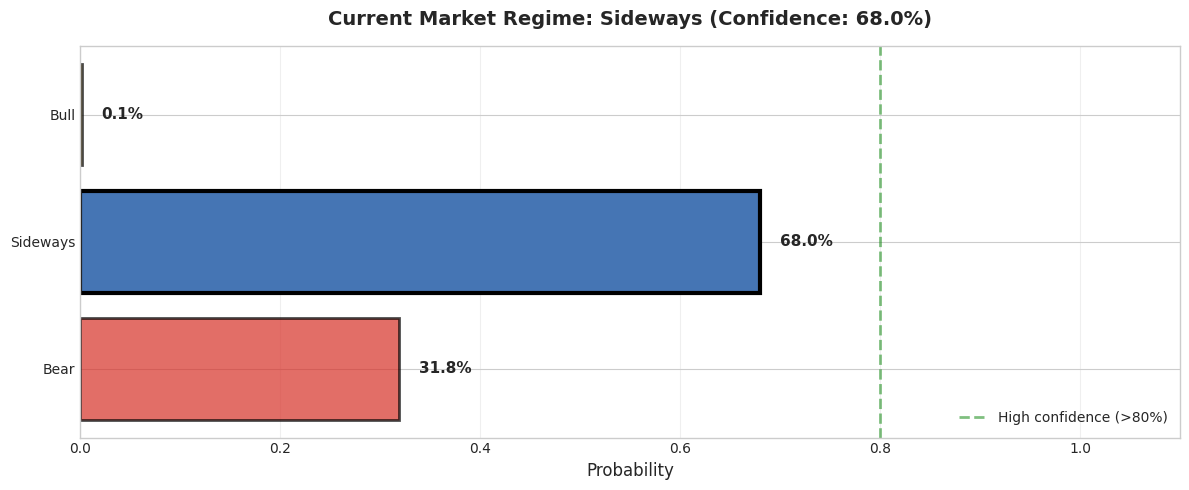


Current Market Status
  Date:       2025-10-14
  Regime:     Sideways
  Confidence: 68.0%
  Duration:   24 days in current regime


In [5]:
# Analyze current regime
current = result.iloc[-1]
current_regime = current['regime_name']

# Count consecutive days in regime
days_in_regime = 1
for i in range(len(result)-2, -1, -1):
    if result.iloc[i]['regime_name'] == current_regime:
        days_in_regime += 1
    else:
        break

# Get state probabilities
state_probs = []
state_names = []
for state in range(n_states):
    col_name = f'state_{state}_prob'
    if col_name in result.columns:
        prob = current[col_name]
        # Find regime name for this state
        state_regime = result[result['predicted_state'] == state]['regime_name'].iloc[0] \
                      if len(result[result['predicted_state'] == state]) > 0 else f"State {state}"
        state_probs.append(prob)
        state_names.append(state_regime)

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 5))

# Get colors for bars
unique_regimes = sorted(result['regime_name'].unique())
from hidden_regime.visualization import get_regime_colors
color_list = get_regime_colors(len(unique_regimes), color_scheme="colorblind_safe")
regime_colors = dict(zip(unique_regimes, color_list))
bar_colors = [regime_colors.get(name, 'gray') for name in state_names]

# Create horizontal bar chart
bars = ax.barh(state_names, state_probs, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=2)

# Highlight the current regime (max probability)
max_idx = np.argmax(state_probs)
bars[max_idx].set_alpha(1.0)
bars[max_idx].set_linewidth(3)

# Add percentage labels
for i, (bar, prob) in enumerate(zip(bars, state_probs)):
    ax.text(prob + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{prob*100:.1f}%', ha='left', va='center', fontweight='bold', fontsize=11)

# Formatting
ax.set_xlim(0, 1.1)
ax.set_xlabel('Probability', fontsize=12)
ax.set_title(f'Current Market Regime: {current_regime} ' +
             f'(Confidence: {current["confidence"]*100:.1f}%)', 
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='x')

# Add vertical line at confidence threshold
ax.axvline(x=0.8, color='green', linestyle='--', alpha=0.5, linewidth=2, label='High confidence (>80%)')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Print summary
print(f"\nCurrent Market Status")
print("=" * 70)
print(f"  Date:       {result.index[-1].date()}")
print(f"  Regime:     {current_regime}")
print(f"  Confidence: {current['confidence']*100:.1f}%")
print(f"  Duration:   {days_in_regime} days in current regime")
print("=" * 70)

## 5. Regime Duration Analysis

### Expected Regime Duration

From the HMM transition matrix $\mathbf{A}$, the expected duration in regime $k$ is:

$$E[\tau_k] = \frac{1}{1 - A_{kk}}$$

Where $A_{kk} = P(\text{state}_{t+1} = k \mid \text{state}_t = k)$ is the probability of staying in the same regime.

**Example**: If $A_{kk} = 0.90$, then $E[\tau] = \frac{1}{1-0.90} = 10$ days.

### Why Duration Matters

- **Short regimes (1-3 days)**: Possible overfitting or high-frequency market noise
- **Medium regimes (5-15 days)**: Typical market regime persistence
- **Long regimes (20+ days)**: Strong, stable market conditions

Duration analysis validates that the HMM is finding **real market patterns**, not random noise.

In [6]:
# Calculate regime durations
def calculate_regime_durations(df):
    """Calculate duration of each regime period"""
    durations = []
    current_regime = df.iloc[0]['regime_name']
    current_duration = 1
    
    for i in range(1, len(df)):
        if df.iloc[i]['regime_name'] == current_regime:
            current_duration += 1
        else:
            durations.append({
                'regime': current_regime,
                'duration': current_duration,
                'start': df.index[i-current_duration],
                'end': df.index[i-1]
            })
            current_regime = df.iloc[i]['regime_name']
            current_duration = 1
    
    # Add final period
    durations.append({
        'regime': current_regime,
        'duration': current_duration,
        'start': df.index[len(df)-current_duration],
        'end': df.index[-1]
    })
    
    return pd.DataFrame(durations)

durations_df = calculate_regime_durations(result)

# Display statistics
print("Regime Duration Statistics")
print("=" * 70)
print(f"Total regime transitions: {len(durations_df)}\n")

for regime in sorted(durations_df['regime'].unique()):
    regime_durs = durations_df[durations_df['regime'] == regime]['duration']
    
    print(f"{regime}:")
    print(f"  Occurrences: {len(regime_durs)} periods")
    print(f"  Average:     {regime_durs.mean():.1f} days  (median: {regime_durs.median():.0f})")
    print(f"  Range:       {regime_durs.min()} - {regime_durs.max()} days")
    print()

# Show longest periods
print("Longest Regime Periods:")
print("-" * 70)
longest = durations_df.nlargest(5, 'duration')
for idx, row in longest.iterrows():
    print(f"  {row['regime']:<12} {row['duration']:>3} days  " +
          f"({row['start'].date()} → {row['end'].date()})")
print("=" * 70)

Regime Duration Statistics
Total regime transitions: 75

Bear:
  Occurrences: 11 periods
  Average:     9.8 days  (median: 6)
  Range:       1 - 40 days

Bull:
  Occurrences: 32 periods
  Average:     3.2 days  (median: 3)
  Range:       1 - 10 days

Sideways:
  Occurrences: 32 periods
  Average:     9.0 days  (median: 5)
  Range:       1 - 39 days

Longest Regime Periods:
----------------------------------------------------------------------
  Bear          40 days  (2025-02-24 → 2025-04-21)
  Sideways      39 days  (2025-07-16 → 2025-09-09)
  Sideways      34 days  (2023-11-15 → 2024-01-04)
  Sideways      24 days  (2025-09-11 → 2025-10-14)
  Sideways      22 days  (2024-11-20 → 2024-12-20)


## 6. Visualization

Three-panel visualization showing:
1. **Price with regime shading**: Visual alignment of regimes with price action
2. **Confidence levels**: How certain the model is about each regime
3. **Regime timeline**: Sequential regime transitions

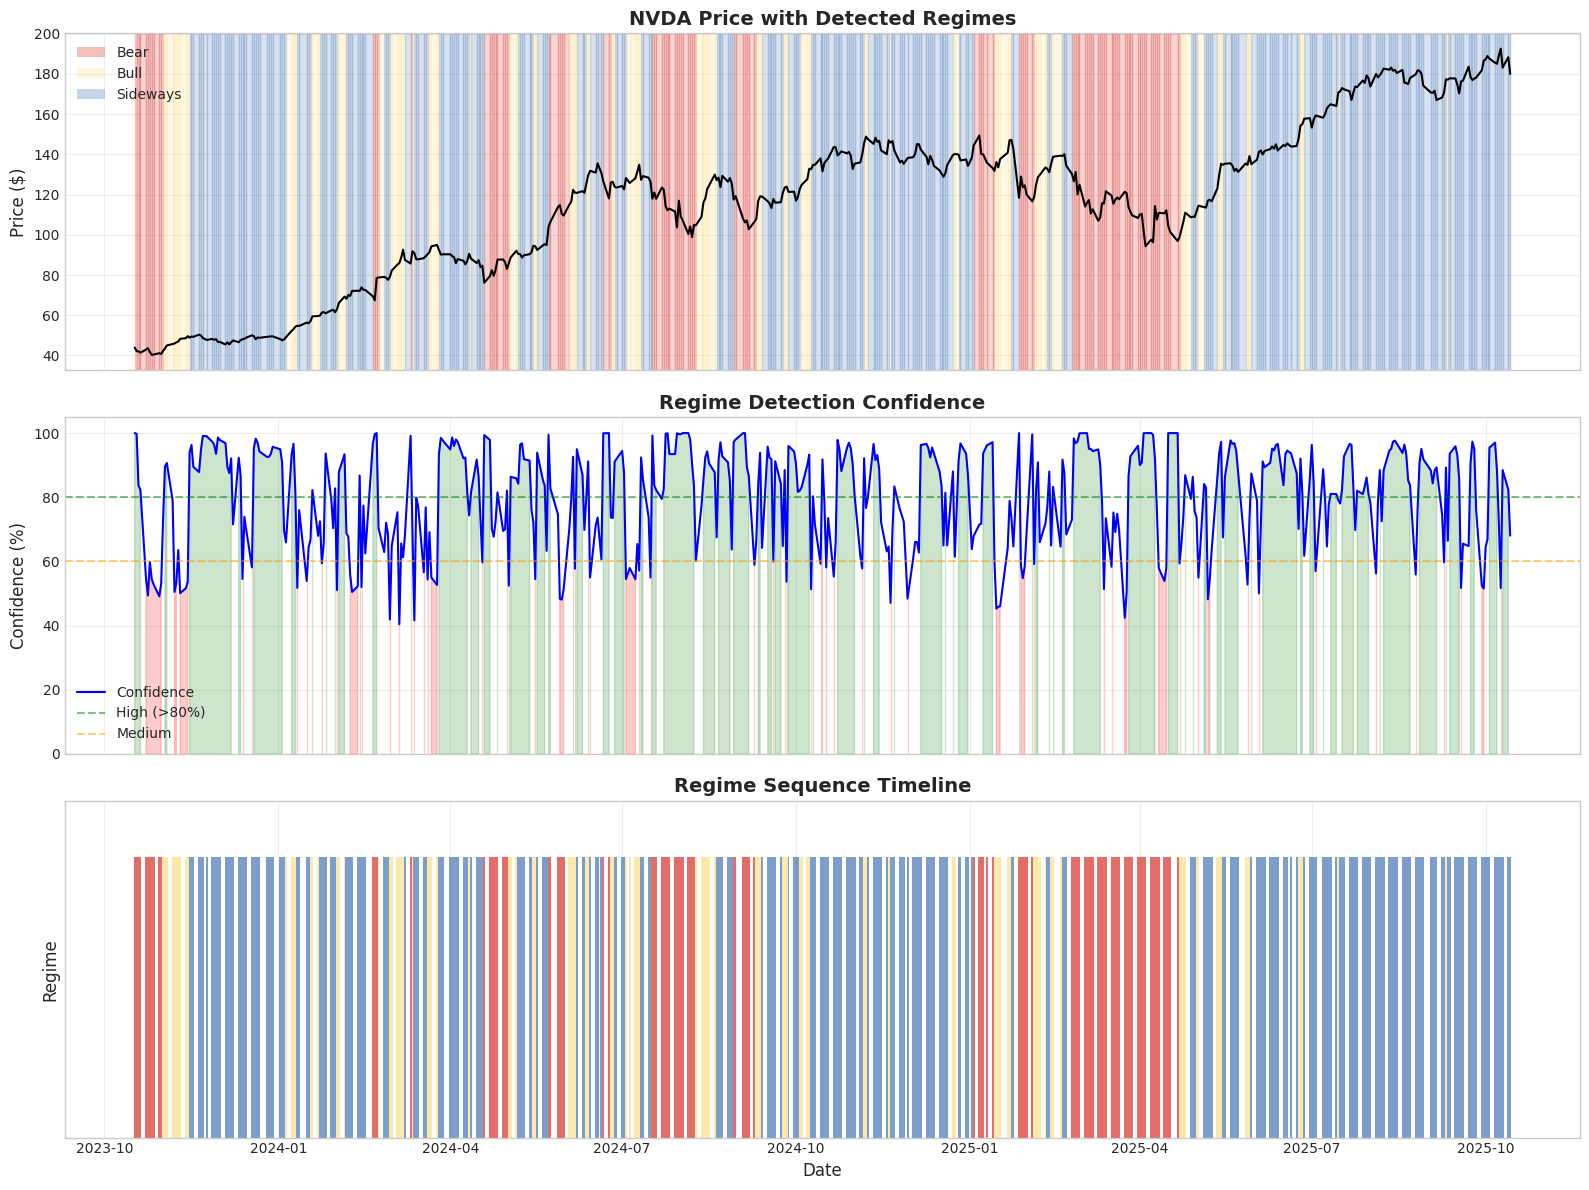

In [7]:
# Create regime visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Get raw price data
raw_data = pipeline.data.get_all_data()
close_col = next((col for col in raw_data.columns if col.lower() == 'close'), None)

if close_col is None:
    raise ValueError("Could not find 'close' column in data")

# Get regime colors
unique_regimes = sorted(result['regime_name'].unique())
from hidden_regime.visualization import get_regime_colors
color_list = get_regime_colors(len(unique_regimes), color_scheme="colorblind_safe")
regime_colors = dict(zip(unique_regimes, color_list))

# Panel 1: Price with regime shading
ax = axes[0]
ax.plot(raw_data.index, raw_data[close_col], linewidth=1.5, color='black', zorder=2)
ax.set_ylabel('Price ($)', fontsize=12)
ax.set_title(f'{ticker} Price with Detected Regimes', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Shade background by regime
for i in range(len(result)):
    regime = result.iloc[i]['regime_name']
    color = regime_colors.get(regime, 'gray')
    ax.axvspan(result.index[i], result.index[min(i+1, len(result)-1)], 
               alpha=0.2, color=color, zorder=1)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=regime_colors.get(r, 'gray'), alpha=0.3, label=r) 
                   for r in unique_regimes]
ax.legend(handles=legend_elements, loc='upper left')

# Panel 2: Confidence levels
ax = axes[1]
confidence_pct = result['confidence'] * 100

ax.plot(result.index, confidence_pct, linewidth=1.5, color='blue', label='Confidence')
ax.axhline(y=80, color='green', linestyle='--', alpha=0.5, label='High (>80%)')
ax.axhline(y=60, color='orange', linestyle='--', alpha=0.5, label='Medium')

# Shade confidence regions
ax.fill_between(result.index, 0, confidence_pct, 
                where=(confidence_pct > 80), alpha=0.2, color='green')
ax.fill_between(result.index, 0, confidence_pct, 
                where=(confidence_pct < 60), alpha=0.2, color='red')

ax.set_ylabel('Confidence (%)', fontsize=12)
ax.set_title('Regime Detection Confidence', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='lower left')
ax.set_ylim(0, 105)

# Panel 3: Regime timeline
ax = axes[2]
for i in range(len(result)):
    regime = result.iloc[i]['regime_name']
    color = regime_colors.get(regime, 'gray')
    ax.bar(result.index[i], 1, width=1, color=color, edgecolor='none', alpha=0.7)

ax.set_ylabel('Regime', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Regime Sequence Timeline', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.2)
ax.set_yticks([])
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 7. Model Comparison

### Selecting Optimal Number of States

**Model complexity tradeoff**:
- **Too few states**: Cannot capture market nuances
- **Too many states**: Overfitting, very short regimes

**Validation metrics**:
1. **Average duration**: Should be 5+ days for meaningful regimes
2. **Confidence**: Higher confidence indicates clearer regime separation
3. **Number of parameters**: $n_{\text{params}} = n^2 + 2n$ for $n$ states
4. **Interpretability**: Can you explain what each regime represents?

In [8]:
# Compare models with different numbers of states
comparison_results = []

print("Training models with 2-5 states...\n")

for n in [2, 3, 4, 5]:
    print(f"  {n} states... ", end='', flush=True)
    
    test_pipeline = hr.create_financial_pipeline(
        ticker=ticker,
        n_states=n,
        include_report=False
    )
    
    _ = test_pipeline.update()
    test_result = test_pipeline.component_outputs['analysis']
    
    # Calculate metrics
    n_params = n**2 + 2*n  # Transitions + emissions
    n_obs = len(test_result)
    switches = (test_result['predicted_state'].diff() != 0).sum()
    avg_duration = n_obs / switches if switches > 0 else n_obs
    avg_conf = test_result['confidence'].mean() * 100
    
    comparison_results.append({
        'States': n,
        'Parameters': n_params,
        'Switches': switches,
        'Avg Duration': f"{avg_duration:.1f}",
        'Avg Confidence': f"{avg_conf:.1f}%"
    })
    
    print("done")

# Display comparison table
comp_df = pd.DataFrame(comparison_results)
print("\n" + "=" * 70)
print("Model Comparison Results")
print("=" * 70)
print(comp_df.to_string(index=False))
print("=" * 70)

Training models with 2-5 states...

  2 states... Training on 500 observations (removed 0 NaN values)
done
  3 states... Training on 500 observations (removed 0 NaN values)
done
  4 states... Training on 500 observations (removed 0 NaN values)
done
  5 states... Training on 500 observations (removed 0 NaN values)
done

Model Comparison Results
 States  Parameters  Switches Avg Duration Avg Confidence
      2           8        24         20.8          89.2%
      3          15        75          6.7          79.5%
      4          24       101          5.0          78.8%
      5          35       114          4.4          78.7%


### Selection Guidelines

**Interpreting the results**:

| States | Typical Use Case | Watch Out For |
|--------|------------------|---------------|
| **2** | Simple bull/bear classification | May miss sideways markets |
| **3** | Bear/Sideways/Bull (recommended) | Good balance |
| **4** | Adding crisis or rally states | Check duration > 5 days |
| **5+** | Very granular regimes | Often overfits, short regimes |

**Red flags**:
- ⚠️ Average duration < 5 days → Likely overfitting
- ⚠️ Confidence < 60% → Poor regime separation
- ⚠️ Too many switches → Capturing noise, not signal

**Recommended**: Start with 3 states. Add more only if:
1. Durations remain meaningful (>5 days)
2. Each regime has clear interpretation
3. Validation on out-of-sample data shows improvement

## 7. Model Comparison

Compare different numbers of states to find the optimal model complexity.

## 8. Best Practices for Regime Detection

### ✓ DO These Things

**1. Always Use Log Returns**
- Ensures stationarity (required for HMMs)
- Proper statistical properties
- Cross-asset comparability

**2. Let Data Determine Regimes**
- Use threshold-based classification
- Don't force "Bear/Bull" labels by sorting state indices
- Examine emission parameters before labeling

**3. Check Confidence Levels**
- Low confidence → regime uncertainty or transitions
- High confidence → reliable regime signals
- Use confidence for position sizing

**4. Validate Regime Duration**
- Very short regimes (< 3 days) → possible overfitting
- Typical regimes (5-15 days) → reasonable persistence
- Long regimes (20+ days) → strong, stable conditions

**5. Compare Multiple Models**
- Try 2-5 states systematically
- Balance fit quality vs complexity
- Use validation metrics (duration, confidence)

**6. Monitor Regime Changes**
- Large parameter shifts → market structure changes
- Regime transition patterns → leading indicators
- Confidence drops → early warning signals

---

### ⚠️ DON'T Do These Things

**1. Don't Use Raw Prices**
- Prices are non-stationary
- Violates HMM assumptions
- Produces invalid inferences

**2. Don't Force Regime Labels**
- State 0 ≠ automatically "Bear"
- Let emission means determine regime types
- Thresholds should be data-driven

**3. Don't Ignore Low Confidence**
- Low confidence carries information
- Often signals regime transitions
- Critical for risk management

**4. Don't Assume Stationarity**
- Market regimes evolve over time
- Parameters change with market structure
- Regular retraining may be needed

**5. Don't Overtrain**
- More states ≠ better model
- 5+ states often overfit
- Focus on interpretability

**6. Don't Use Single Random Seed**
- HMMs have local optima
- Results can vary by initialization
- Consider multiple runs or robust initialization

---

### Production Checklist

Before deploying for real trading decisions:

- [ ] Verified log returns are used (not prices or simple returns)
- [ ] Checked regime durations are reasonable (not too short)
- [ ] Validated confidence levels are meaningful
- [ ] Compared 2-5 states and selected optimal complexity
- [ ] Examined regime characteristics match market intuition
- [ ] Tested on out-of-sample data
- [ ] Established monitoring for regime changes
- [ ] Integrated with risk management system (see Notebook 4)

---

## 9. Conclusion & Next Steps

### What You've Accomplished

Congratulations! You now have a complete understanding of regime detection using HMMs:

**From Notebook 1 (Mathematical Foundation)**:
- ✓ Why log returns are mathematically necessary
- ✓ Stationarity, additivity, and scale invariance
- ✓ Properties required for statistical modeling

**From Notebook 2 (HMM Mechanics)**:
- ✓ How HMMs represent market regimes
- ✓ What transition matrices and emissions mean
- ✓ Viterbi vs forward-backward algorithms
- ✓ Interpreting states without forcing labels

**From Notebook 3 (Production Pipeline)** - This Notebook:
- ✓ One-line pipeline setup
- ✓ Automated threshold-based regime classification
- ✓ Regime duration and persistence analysis
- ✓ Model selection (2-5 states comparison)
- ✓ Visualization and interpretation
- ✓ Best practices for production use

---

### The Complete Learning Path

```
Notebook 1: Mathematical Foundation (WHY)
    ↓
Notebook 2: HMM Mechanics (HOW)
    ↓
Notebook 3: Production Pipeline (USING) ← You are here
    ↓
Notebook 4: Trading Applications (PROFITING) ← Next step
```

---

### What's Next: Notebook 4 - Advanced Trading Applications

You can now **detect regimes**. Notebook 4 teaches you how to **USE them for trading**:

#### Part A: Regime-Specific Risk Management
- VaR and Expected Shortfall by regime
- Maximum drawdown analysis
- Sharpe ratios and risk-adjusted returns
- Dynamic position sizing based on regime risk

#### Part B: Technical Indicator Integration  
- Combining HMM regimes with RSI, MACD, Bollinger Bands
- Agreement/disagreement analysis
- When to trust HMMs vs indicators
- Ensemble signal generation

#### Part C: Portfolio Applications
- Position signals (LONG/SHORT/NEUTRAL)
- Confidence-weighted position sizing
- Signal strength methodology
- Risk-adjusted portfolio allocation

#### Part D: Backtesting & Validation
- Hypothetical performance comparison
- Walk-forward analysis
- Regime-based strategy testing
- Out-of-sample validation

---

### Practical Next Steps

**If you want to continue learning**:
1. Open **Notebook 4** to learn trading applications
2. Apply these techniques to your own tickers
3. Experiment with different time periods
4. Try different numbers of states

**If you're ready for production**:
1. Review the best practices checklist above
2. Test on multiple assets and time periods
3. Validate regime stability over time
4. Integrate with your existing trading system
5. Start with paper trading before real capital

**If you want to customize**:
1. Modify threshold values for regime classification
2. Add your own features beyond log returns
3. Implement custom risk metrics
4. Integrate with other analysis tools

---

### Key Takeaways

> **Regime detection is a tool, not a crystal ball.**
>
> Use it to:
> - Understand current market conditions
> - Adjust risk based on regime characteristics  
> - Combine with other analysis methods
> - Make more informed trading decisions
>
> Don't expect it to:
> - Predict future price movements perfectly
> - Work in all market conditions
> - Replace fundamental analysis
> - Guarantee profitable trades

---

### Resources

- **Documentation**: [Hidden Regime Docs](https://hiddenregime.com/docs)
- **Examples**: More examples in `/examples` directory
- **Issues**: Report bugs at GitHub
- **Community**: Share strategies and learn from others

---

**Ready for trading applications? Open Notebook 4!**